<a href="https://colab.research.google.com/github/vishakhun/Data-Analysis-practice/blob/main/Ride_Sharing_Demand_Forecasting_and_Pricing_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ride-Sharing Demand Forecasting and Pricing Optimization



##Introduction:
This project aims to analyze and forecast demand in the ride-sharing sector and optimize pricing strategies to maximize revenue. Utilizing a simulated dataset, we'll employ machine learning techniques to predict ride demand based on historical data and apply optimization methods to determine the most profitable pricing strategy.

##Objectives:

* Perform exploratory data analysis to understand demand patterns and
influential factors.
* Forecast ride demand using a machine learning model.
* Optimize pricing strategies to enhance revenue, applying mathematical optimization techniques.


###Importing Necessary Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import seaborn as sns

### Creation of dummy data for analysis

In [8]:
# Create a date range
date_rng = pd.date_range(start='1/1/2022', end='3/31/2022', freq='H')

# Create a DataFrame
df = pd.DataFrame(date_rng, columns=['date'])
df['demand'] = np.random.randint(0, 100, size=(len(date_rng)))

# Simulate some factors that might affect demand
df['day_of_week'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour

# Increase demand during peak hours (e.g., 6-9 AM and 4-7 PM)
df['demand'] += df['hour'].apply(lambda x: 30 if x in range(6, 10) or x in range(16, 20) else 0)

# Increase demand on weekends
df['demand'] += df['day_of_week'].apply(lambda x: 20 if x >= 5 else 0)

# Add some noise
df['demand'] += np.random.randint(-10, 10, size=(len(date_rng)))

# Ensure demand is never negative
df['demand'] = df['demand'].apply(lambda x: max(x, 0))

###Data Loading and Preparation

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2137 non-null   datetime64[ns]
 1   demand       2137 non-null   int64         
 2   day_of_week  2137 non-null   int64         
 3   hour         2137 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 66.9 KB


In [19]:
df.head()

,date,demand,day_of_week,hour,day_0,day_1,day_2,day_3,day_4,day_5,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2022-01-01 00:00:00,57,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2022-01-01 01:00:00,52,5,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-01 02:00:00,88,5,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2022-01-01 03:00:00,57,5,3,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-01 04:00:00,49,5,4,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour

###Exploratory Data Analysis and Visualization

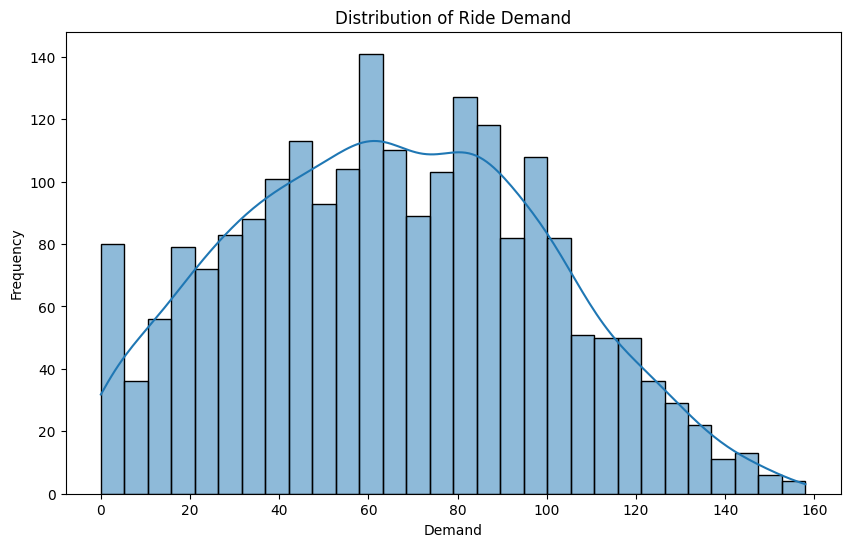

In [12]:
# Demand distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['demand'], bins=30, kde=True)
plt.title('Distribution of Ride Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.show()

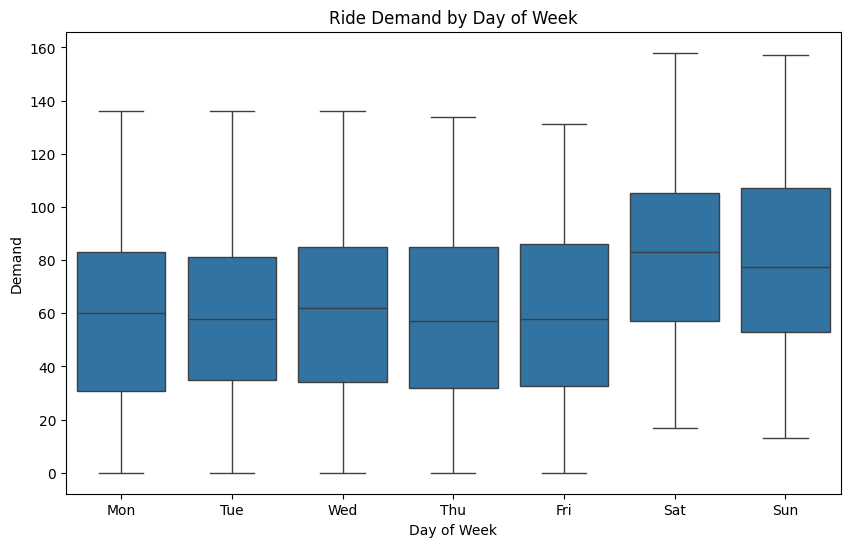

In [13]:
# Demand by day of the week
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='demand', data=df)
plt.title('Ride Demand by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Demand')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


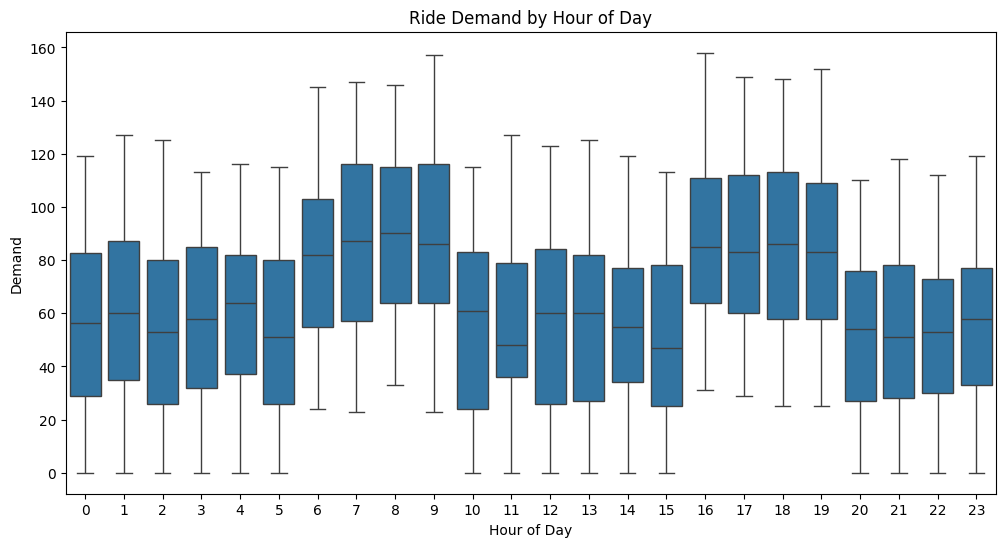

In [14]:
# Demand by hour of the day
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='demand', data=df)
plt.title('Ride Demand by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Demand')
plt.show()

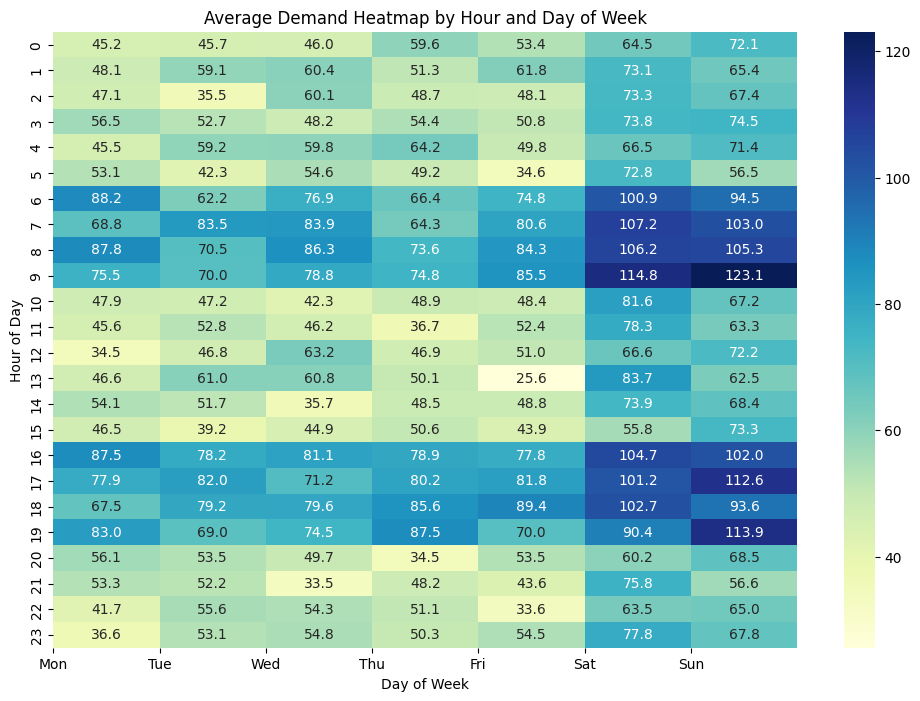

In [15]:
# Heatmap of demand by day and hour
pivot_table = df.pivot_table(values='demand', index='hour', columns='day_of_week', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Average Demand Heatmap by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

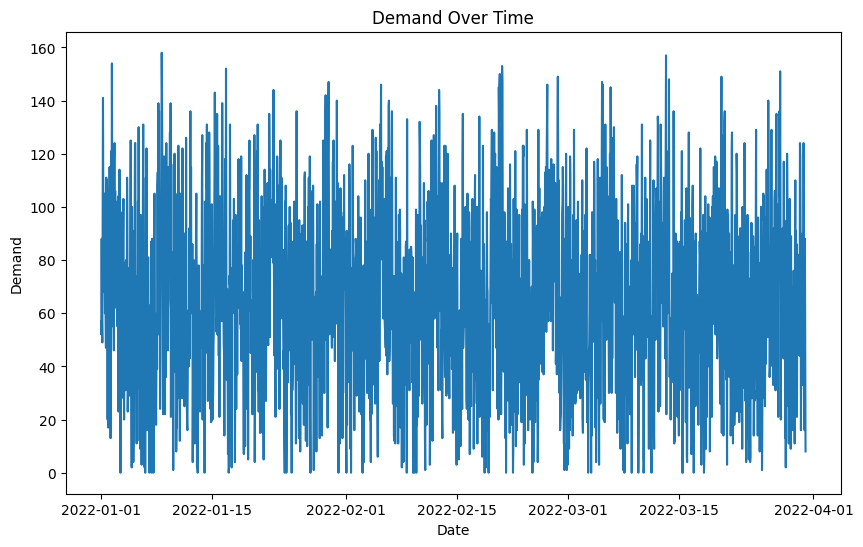

In [16]:
# Plot demand over time
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['demand'])
plt.title('Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

###Machine Learning - Demand Forecasting

In [17]:
# Feature engineering - create dummy variables for days and hours
df = pd.concat([df, pd.get_dummies(df['day_of_week'], prefix='day'), pd.get_dummies(df['hour'], prefix='hour')], axis=1)

# Define features and target variable
X = df.drop(['date', 'demand', 'day_of_week', 'hour'], axis=1)
y = df['demand']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 868.5619067610982


###Pricing Strategy Optimization

In [20]:
from scipy.optimize import minimize

# Define a simple demand function
def demand_function(price):
    return -price * 0.5 + 50  # example function

# Define the revenue function
def revenue_function(price):
    return price * demand_function(price)

# We want to maximize revenue, so we minimize the negative revenue
result = minimize(lambda x: -revenue_function(x), x0=[10])
optimal_price = result.x[0]
print(f'Optimal Price: {optimal_price}')

Optimal Price: 49.99999910580676
